# Cell phone plans analysis

***

## Project description

### The objective

Analyze the data on clients' behavior and determine which prepaid plan brings in more revenue. Test the hypotheses:
- The average revenue from users of Ultimate and Surf calling plans differs.
- The average revenue from users in NY-NJ area is different from that of the users from other regions.


### Conditions: the plans description

Megaline rounds seconds up to minutes, and megabytes to gigabytes. For calls, each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.

**Surf**
1. Monthly charge: \$20
2. 500 monthly minutes, 50 texts, and 15 GB of data
3. After exceeding the package limits:
    - 1 minute: 3 cents
    - 1 text message: 3 cents
    - 1 GB of data: $10

**Ultimate**
1. Monthly charge: \$70
2. 3000 monthly minutes, 1000 text messages, and 30 GB of data
3. After exceeding the package limits:
    - 1 minute: 1 cent
    - 1 text message: 1 cent
    - 1 GB of data: $7

### Data description

The `users` table (data on users):

- *user_id* — unique user identifier
- *first_name* — user's name
- *last_name* — user's last name
- *age* — user's age (years)
- *reg_date* — subscription date (dd, mm, yy)
- *churn_date* — the date the user stopped using the service (if the value is missing, the calling plan was being used when this database was extracted)
- *city* — user's city of residence
- *plan* — calling plan name

The `calls` table (data on calls):

- *id* — unique call identifier
- *call_date* — call date
- *duration* — call duration (in minutes)
- *user_id* — the identifier of the user making the call

The `messages` table (data on texts):

- *id* — unique text message identifier
- *message_date* — text message date
- *user_id* — the identifier of the user sending the text

The `internet` table (data on web sessions):

- *id* — unique session identifier
- *mb_used* — the volume of data spent during the session (in megabytes)
- *session_date* — web session date
- *user_id* — user identifier

The `plans` table (data on the plans):

- *plan_name* — calling plan name
- *usd_monthly_fee* — monthly charge in US dollars
- *minutes_included* — monthly minute allowance
- *messages_included* — monthly text allowance
- *mb_per_month_included* — data volume allowance (in megabytes)
- *usd_per_minute* — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)
- *usd_per_message* — price per text after exceeding the package limits
- *usd_per_gb* — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)

***

## Libraries and settings

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats as st
from scipy.stats import bartlett

from functools import reduce

In [2]:
# settings for graphs
plt.style.use("seaborn")
sns.set_style("dark", {"axes.facecolor": ".95"})
plt.rcParams["figure.figsize"] = (8, 4)
%config InlineBackend.figure_format = "retina"

***

## Data preprocessing

### Read and look at the data

#### Users

In [3]:
users = pd.read_csv(f'datasets/megaline_users.csv', 
                    parse_dates=["reg_date","churn_date"])

In [4]:
users.sample()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
347,1347,Trey,Lynch,65,"Charleston-North Charleston, SC MSA",2018-06-17,ultimate,NaT


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [6]:
users["age"].describe()

count    500.000000
mean      45.486000
std       16.972269
min       18.000000
25%       30.000000
50%       46.000000
75%       61.000000
max       75.000000
Name: age, dtype: float64

According to the data description, the `churn_date` missing means that the client is still using the company's services.

In [7]:
# see if any user IDs are used more than once
users["user_id"].nunique()

500

In [8]:
# check whether there are any name duplicates
users.duplicated(subset=['first_name','last_name']).sum()

0

How long were clients that stopped their service with the company? Can this period be representative for the analysis?

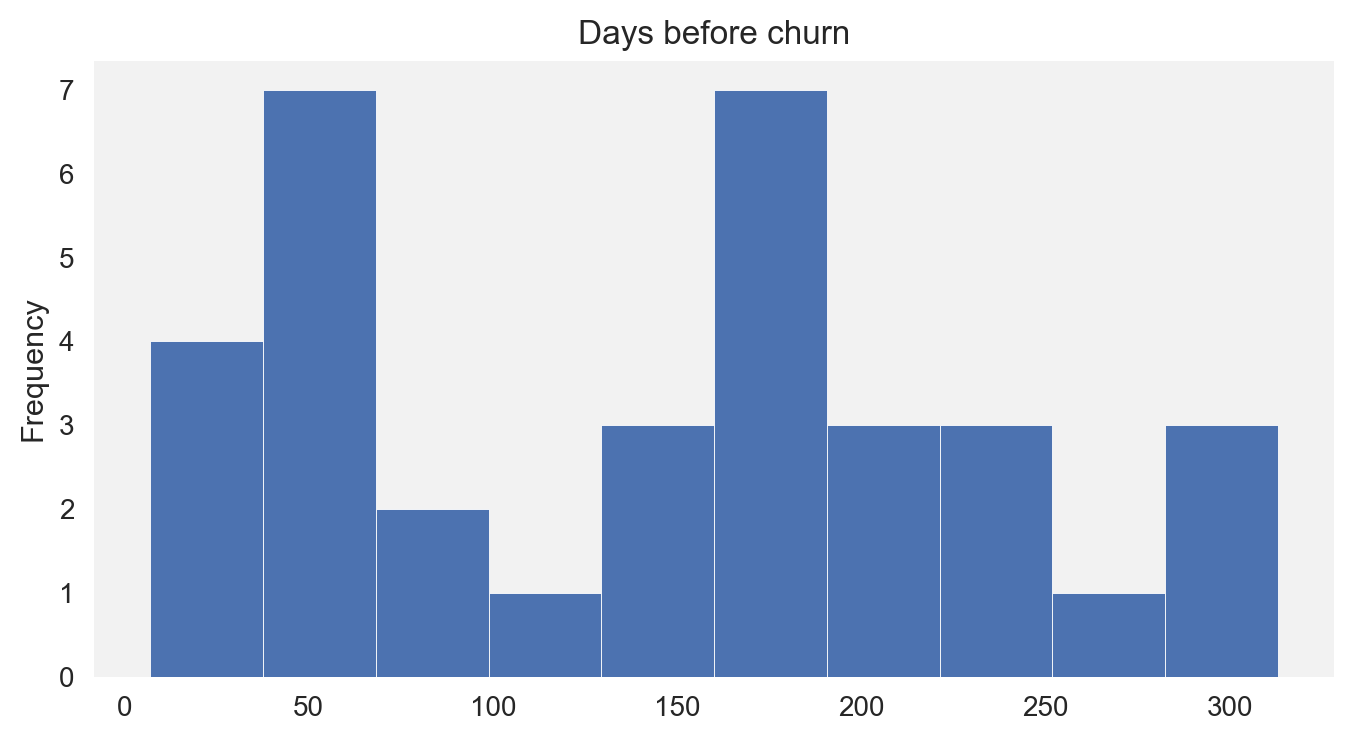

In [9]:
# calculate the duration of the period before churn
churn_period = users["churn_date"] - users["reg_date"]

churn_period.dt.days.plot(
    kind="hist", title="Days before churn"
);

Exclude records that have less than 30 days of data from the further analysis.

In [10]:
# filter the users data
users = users[(users["churn_date"].isna()) | (churn_period.dt.days > 30)]

# see how many records left
users.shape[0]

496

#### Calls

In [11]:
calls = pd.read_csv("datasets/megaline_calls.csv", parse_dates=["call_date"])

In [12]:
calls.sample()

,id,user_id,call_date,duration
3622,1014_1,1014,2018-12-24,0.0


In [13]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


In [14]:
calls["duration"].describe()

count    137735.000000
mean          6.745927
std           5.839241
min           0.000000
25%           1.290000
50%           5.980000
75%          10.690000
max          37.600000
Name: duration, dtype: float64

There are zero values in the duration column. The [documentation](#Description-of-the-plans) says that even a one-second call counts, but there wasn't anything about zero seconds. Check how many of the zero-duration calls there are.

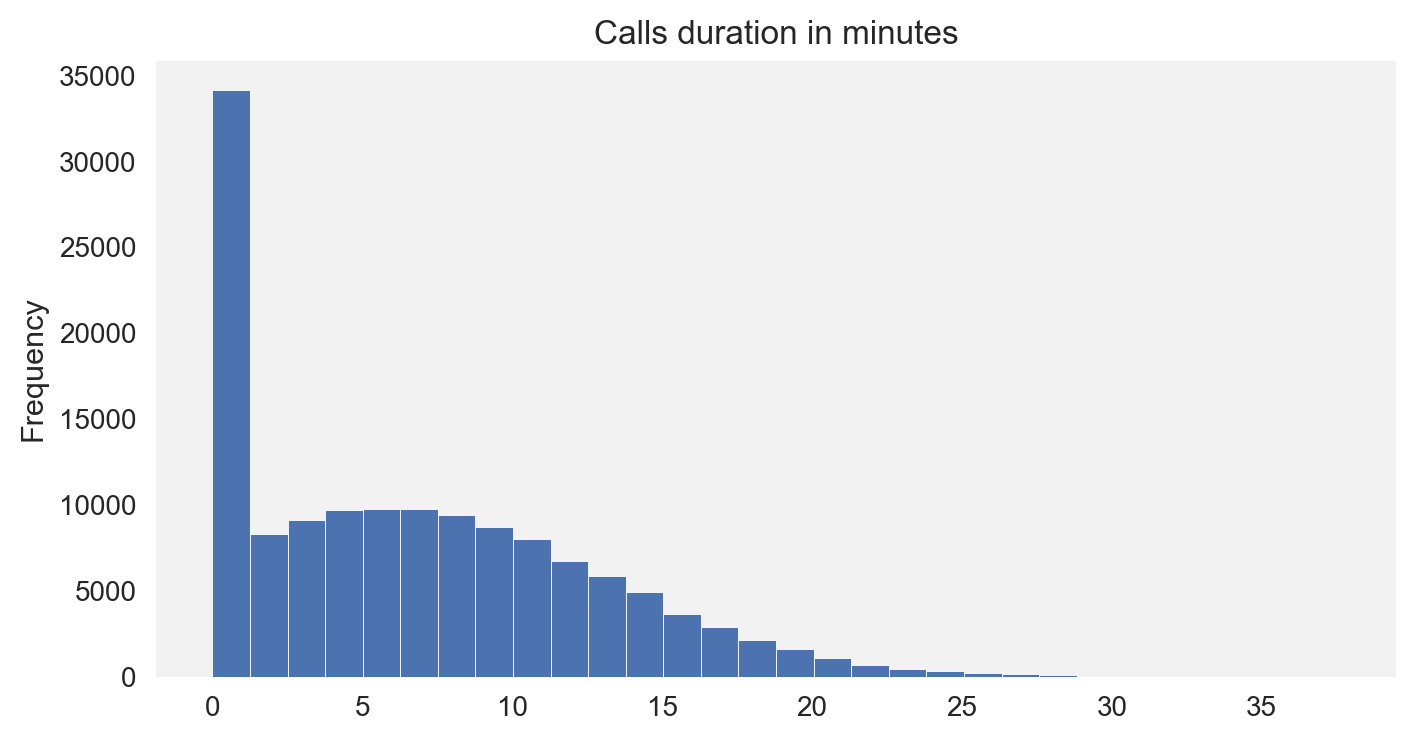

In [15]:
calls["duration"].plot(
    kind="hist", bins=30, title="Calls duration in minutes"
);

These zero values stand out from the overall distribution. Whether it is a technical failure while data processing or some other issue, a call session with zero duration doesn't give any information to analyze.

In [16]:
# remove calls with zero duration
calls = calls[calls["duration"] > 0]

According to the task conditions, each call's duration must be rounded up to the next minute.

In [17]:
calls["duration"] = np.ceil(calls["duration"]).astype(int)
calls.sample()

,id,user_id,call_date,duration
3060,1010_690,1010,2018-03-14,15


In [18]:
# check for duplicates
calls.duplicated().sum()

0

#### Messages

In [19]:
messages = pd.read_csv("datasets/megaline_messages.csv",
                      parse_dates=["message_date"])

In [20]:
messages.sample()

,id,user_id,message_date
16304,1110_195,1110,2018-08-31


In [21]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


In [22]:
messages.duplicated().sum()

0

#### Internet

In [23]:
internet = pd.read_csv("datasets/megaline_internet.csv",
                      parse_dates=["session_date"])

In [24]:
internet.sample()

,id,user_id,session_date,mb_used
84643,1395_8,1395,2018-12-20,110.21


In [25]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [26]:
internet["mb_used"].describe()

count    104825.000000
mean        366.713701
std         277.170542
min           0.000000
25%         136.080000
50%         343.980000
75%         554.610000
max        1693.470000
Name: mb_used, dtype: float64

Look at how many zero internet data there is.

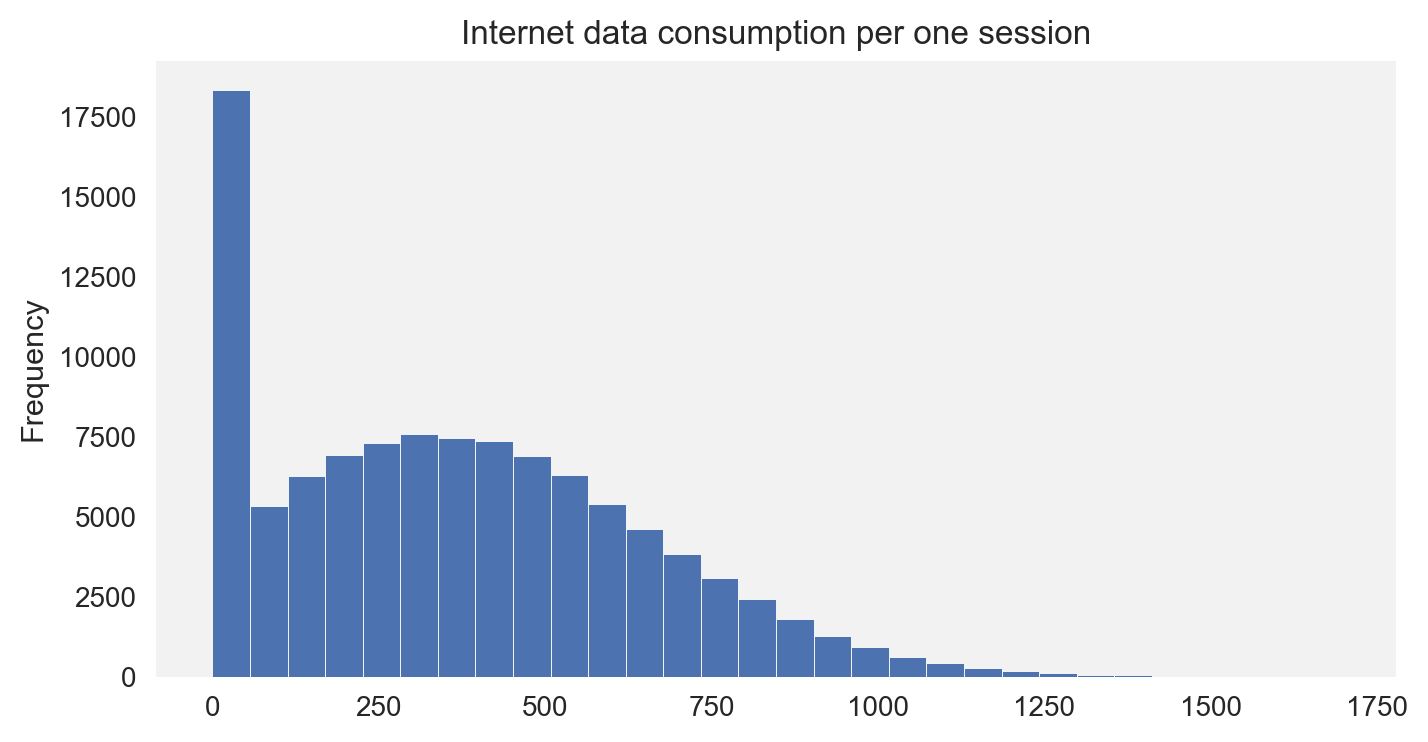

In [27]:
internet["mb_used"].plot(
    kind="hist", bins=30, title="Internet data consumption per one session"
);

The same pattern as for the calls duration. Sessions with zero megabytes used are also not useful for analysis.

In [28]:
# filter the interntet data
internet = internet[internet["mb_used"] > 0 ]

In [29]:
# check for duplicates
internet.duplicated().sum()

0

#### Plans

In [30]:
plans = pd.read_csv("datasets/megaline_plans.csv")
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [31]:
# set the plan name as index (for further use)
plans = plans.set_index("plan_name", drop=True)

# Get the number of prepaid gigabytes.
plans['gb_per_month_included'] = (plans['mb_per_month_included'] / 1024
                                 ).astype(int)

### Calculate monthly totals

The number of calls made and minutes used per month.

In [32]:
# create a new column with the month in which calls were made.
calls["month"] = calls["call_date"].dt.to_period("m")

calls_totals = (calls
                .groupby(["user_id","month"])
                .agg(number_of_calls=("duration","count"), minutes_used=("duration","sum"))
)

calls_totals.sample(3)

,,number_of_calls,minutes_used
user_id,month,,
1053,2018-08,50,479
1144,2018-04,19,163
1475,2018-08,36,340


The number of messages sent each month.

In [33]:
messages['month'] = messages["message_date"].dt.to_period('m')

messages_totals = (messages
                   .groupby(["user_id","month"])
                   .agg(number_of_messages=("message_date", "count"))
                  )

messages_totals.sample(3)

,,number_of_messages
user_id,month,
1304,2018-12,59
1276,2018-11,19
1474,2018-12,40


The volume of internet data used.

In [34]:
internet['month'] = internet["session_date"].dt.to_period('m')

internet_totals = (internet
                   .groupby(["user_id","month"])
                   .agg(gb_used=("mb_used","sum"))
                   .apply(lambda x: np.ceil(x / 1024)) # round to gigabytes
                   .astype(int)
                  )

internet_totals.sample(3)

,,gb_used
user_id,month,
1176,2018-11,28
1399,2018-08,23
1254,2018-11,21


### Create a master dataframe

In [35]:
dataframes = [calls_totals, messages_totals, internet_totals]

monthly_data = (  # merge the first three datasets
    reduce(
        lambda df_left, df_right: pd.merge(df_left, df_right,  on=['user_id','month'], how='outer'),
        dataframes
    )
    .fillna(0) # fill in the options that have not been used with zeros
    .sort_values(by=['user_id','month']) 
    .astype(int)
    .reset_index() # reset the index for the next merge
    .merge(users[['user_id','plan', 'city']], on='user_id', how='left') 
)    # added each user's subscription plan and region info

monthly_data.sample(3)

,user_id,month,number_of_calls,minutes_used,number_of_messages,gb_used,plan,city
642,1135,2018-12,15,142,0,7,ultimate,"Miami-Fort Lauderdale-West Palm Beach, FL MSA"
1535,1334,2018-06,67,561,12,18,surf,"Seattle-Tacoma-Bellevue, WA MSA"
984,1204,2018-11,0,0,42,21,ultimate,"Chicago-Naperville-Elgin, IL-IN-WI MSA"


In [36]:
monthly_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype    
---  ------              --------------  -----    
 0   user_id             2293 non-null   int64    
 1   month               2293 non-null   period[M]
 2   number_of_calls     2293 non-null   int64    
 3   minutes_used        2293 non-null   int64    
 4   number_of_messages  2293 non-null   int64    
 5   gb_used             2293 non-null   int64    
 6   plan                2288 non-null   object   
 7   city                2288 non-null   object   
dtypes: int64(5), object(2), period[M](1)
memory usage: 161.2+ KB


Some rows turned out not having plan info.

In [37]:
# remove recrods without plan inf
monthly_data.dropna(subset="plan", axis=0, inplace=True)

### Add monthly revenue for each user.

In [38]:
# write a function for calculation revenue
def get_revenue_npclip(data):
    
    minutes_used = data['minutes_used']
    number_of_messages = data['number_of_messages']
    gb_used = data['gb_used']
    plan = data['plan']
    
    # assign values corresponding to the user's calling plan.
    minutes_included = plans.loc[plan,'minutes_included']
    usd_per_minute = plans.loc[plan,'usd_per_minute']
    
    messages_included = plans.loc[plan,'messages_included']
    usd_per_message = plans.loc[plan,'usd_per_message']
    
    gb_per_month_included = plans.loc[plan,'gb_per_month_included']
    usd_per_gb = plans.loc[plan,'usd_per_gb']
    
    # get basic monthly charge.
    revenue = plans.loc[plan,'usd_monthly_pay']
    
    # with the np.clip function add revenue when limits are exceeded
    # if the difference is less than zero, clip it to zero 
    # or, if it's greater, keep it as it is and multiply by the tariff
    revenue += (minutes_used - minutes_included).clip(0) * usd_per_minute
    revenue += (number_of_messages - messages_included).clip(0) * usd_per_message
    revenue += (gb_used - gb_per_month_included).clip(0) * usd_per_gb
    
    return revenue

In [39]:
# apply the function and add the revenue column to the dataframe
monthly_data['revenue'] = monthly_data.apply(get_revenue_npclip, axis=1)
monthly_data.sample(3)

,user_id,month,number_of_calls,minutes_used,number_of_messages,gb_used,plan,city,revenue
1576,1340,2018-11,79,655,49,1,surf,"Dallas-Fort Worth-Arlington, TX MSA",24.65
311,1067,2018-11,50,413,39,20,surf,"Grand Rapids-Kentwood, MI MSA",70.00
782,1163,2018-10,65,714,7,20,ultimate,"Los Angeles-Long Beach-Anaheim, CA MSA",70.00


### Average the monthly data per user

In [40]:
data = (monthly_data
        # get the mean values for needed columns, keep info on calling plans
        .pivot_table(index=['user_id','plan','city'], 
                     values=['minutes_used','number_of_messages','gb_used','revenue'])
        .sort_values(by='revenue') 
        .reset_index() # get rid of multiIndex.
       )

data.sample(3)

,user_id,plan,city,gb_used,minutes_used,number_of_messages,revenue
472,1374,surf,"Louisville/Jefferson County, KY-IN MSA",27.222222,289.777778,64.0,156.125556
289,1442,ultimate,"New York-Newark-Jersey City, NY-NJ-PA MSA",15.000000,236.000000,65.0,70.000000
319,1164,ultimate,"Chicago-Naperville-Elgin, IL-IN-WI MSA",14.000000,374.222222,25.0,70.000000


***

## EDA

### Analyze users' behavior

Plot the data fro each column and compare plans.

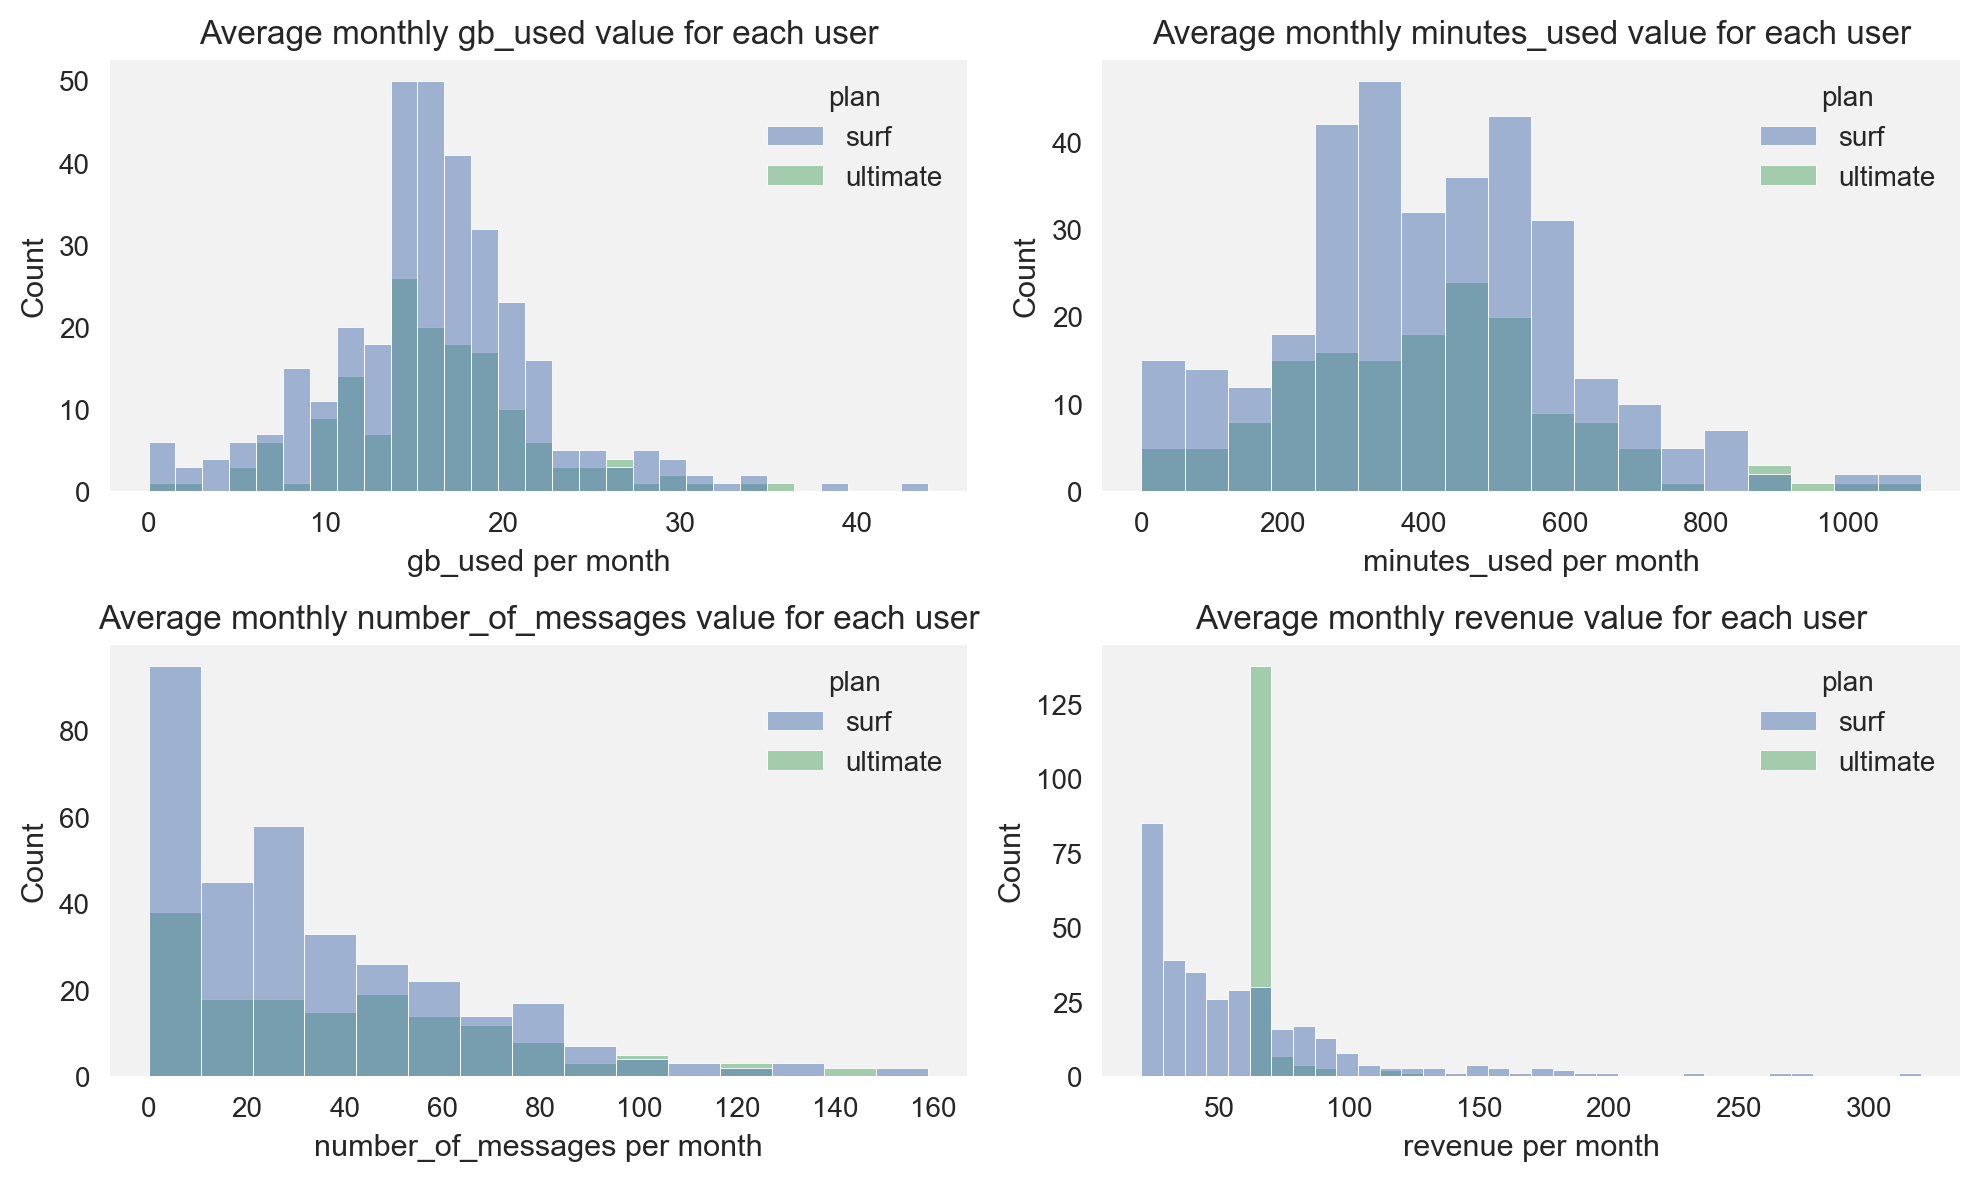

In [41]:
plt.figure(figsize=(10,6))
col_cnt = 0

for col in data.columns[3:]:
    col_cnt += 1
    plt.subplot(2, 2, col_cnt)
    sns.histplot(data, x=col, hue='plan')
    plt.title(f"Average monthly {col} value for each user")
    plt.xlabel(f"{col} per month")
    
plt.tight_layout()

Intermediate conclusions:

**Package options**  
It turns out that users of each plan consume very similar amounts of minutes, messages, and data. The distribution of the `gb_used` column looks the same for both calling plans and can be described as normal (considering the sample size). For the `numbers_of_messages` values distribution shows that people tend to use text messages less.

**Revenue**  
Users of the *ultimate* plant mostly pay the basic monthly charge, while users of the *surf* plan often pay for exceeding their package limits; Also, there are a lot of outliers with much bigger payments than the rest.

Take a closer look at those who pay the most.

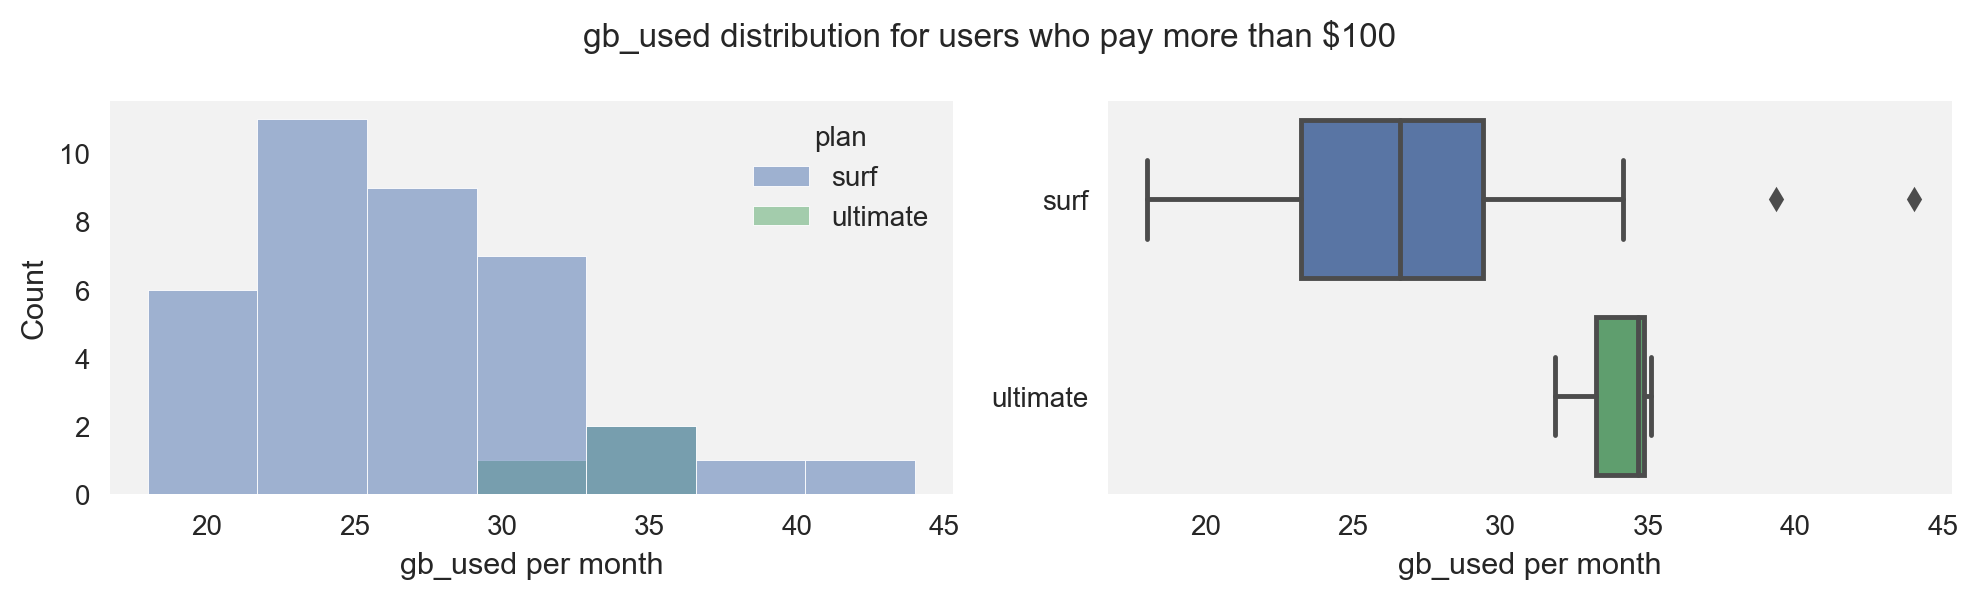

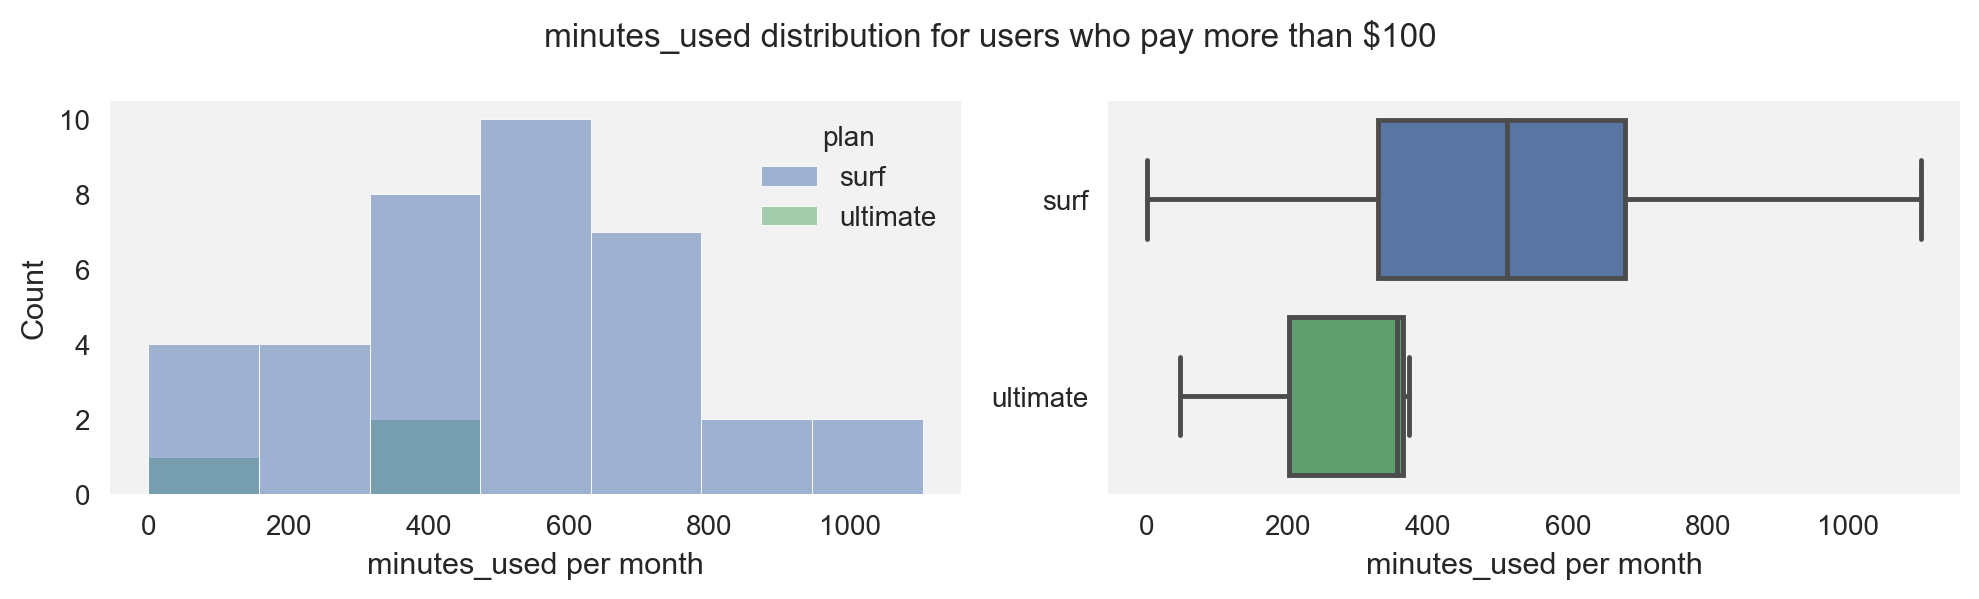

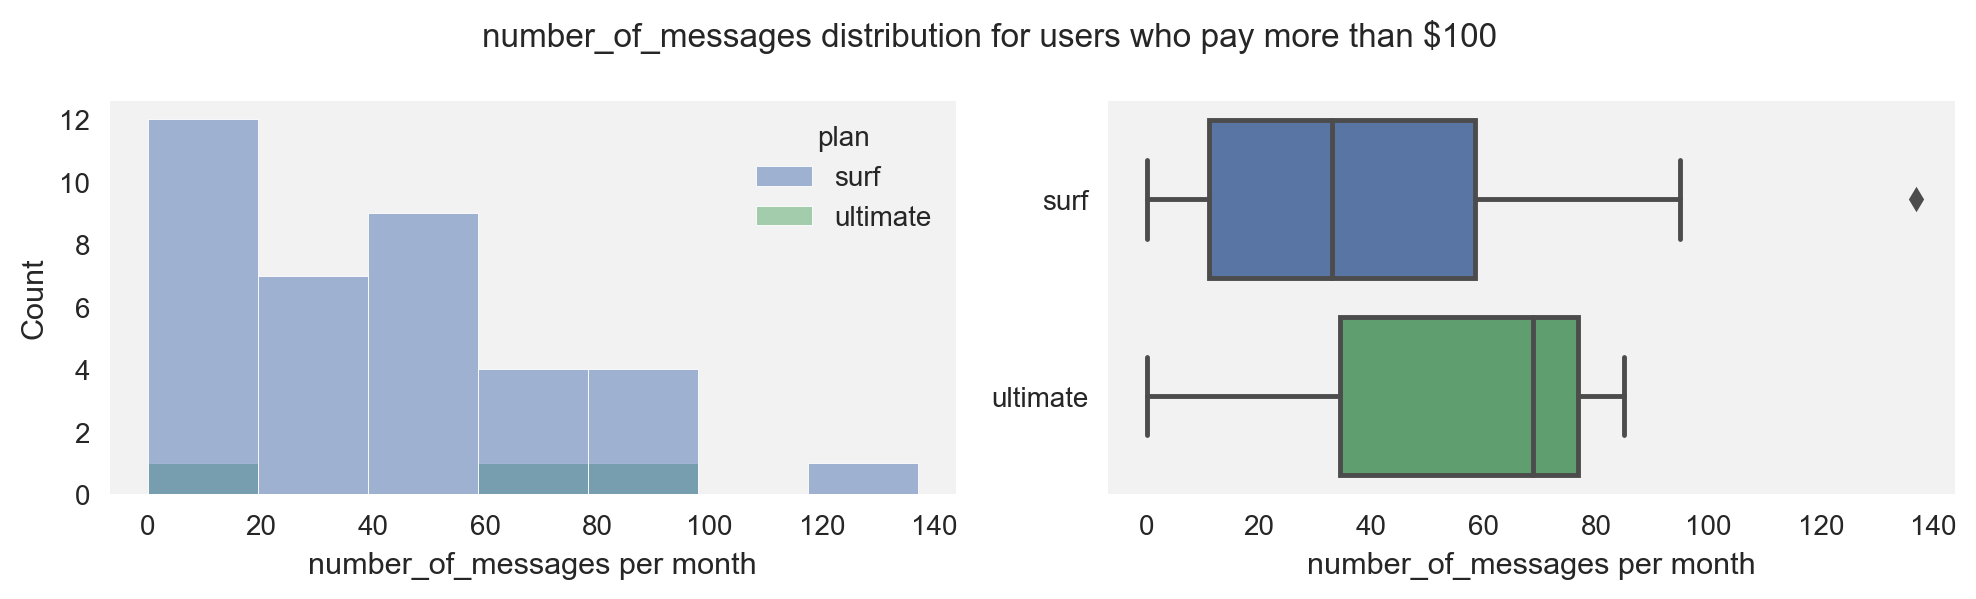

In [42]:
high_revenue = data.query("revenue >= 100")

for col in data.columns[3:-1]:
    
    fig, ax = plt.subplots(1,2, figsize=(10,3)) 
    
    # Set the title.
    fig.suptitle(f"{col} distribution for users who pay more than \$100")
    
    # Create a histogram.
    sns.histplot(data=high_revenue, x=col, hue='plan', ax=ax[0]) 
    ax[0].set_xlabel(f'{col} per month')
    
    # Create a boxplot.
    sns.boxplot(data=high_revenue, x=col, y="plan", ax=ax[1])
    ax[1].set_xlabel(f'{col} per month')
    ax[1].set_ylabel("")
    
    fig.tight_layout()

- Mostly, customers pay extra for [exceeding data limits](#Description-of-the-plans) (there is only 15 GB included in the «surf» package).
- Not so often, customers pays for exceeding their minutes package (500 minutes minutes limit on the *surf*).

### Describe a typical user's needs

In [43]:
# decide the range
est_range = .75

# set the limits for the PPF function 
lower_limit = (1 - est_range) / 2
upper_limit = 1 - (1 - est_range) / 2

# calculate the range for every column
for col in data.columns[3:-1]:

    mean = data[col].mean()
    std = data[col].std()
    
    # build a distribution
    distr = st.norm(mean, std)

    # calculate the ranges
    lower_range = round(np.max([distr.ppf(lower_limit),0]))
    upper_range = round(distr.ppf(upper_limit))
    
    # print the results
    print(f"{est_range:.0%} of {col}: {lower_range} < x < {upper_range}")

75% of gb_used: 9 < x < 23
75% of minutes_used: 181 < x < 638
75% of number_of_messages: 0 < x < 71


**75% of customers require per month:**
- from 9 to 23 gigabytes of data, 
- from 180 to 640 minutes for calls,
- up to 71 messages.

How many customers will be satisfied with the given limits of both plans?

In [44]:
col_pairs = {
    'number_of_messages':'messages_included',
    'minutes_used':'minutes_included',
    'gb_used':'gb_per_month_included'
}

# loop through the list of plans
for plan in plans.index:
    
    print(f'The "{plan}" plan:')
    for col in col_pairs:
        
        # calculate statistics
        mean = data[col].mean()
        std = data[col].std()
        
        # get the package's limit
        limit = plans.loc[plan,col_pairs[col]]
        # build a distribution and calculate percentage expectation
        percent = st.norm(mean, std).cdf(limit)
        
        print(f"{plans.loc[plan,col_pairs[col]]:<3} {col_pairs[col]} is enough for {percent:.0%} of customers")
    print()

The "surf" plan:
50  messages_included is enough for 69% of customers
500 minutes_included is enough for 68% of customers
15  gb_per_month_included is enough for 43% of customers

The "ultimate" plan:
1000 messages_included is enough for 100% of customers
3000 minutes_included is enough for 100% of customers
30  gb_per_month_included is enough for 99% of customers



More than half of users need more data than what the *surf* prepaid package offers. In about 30% cases, package limits of minutes and messages from the same plan are exceeded.  

In contrast, very few users of the *ultimate* plan exceed their data package limit. They do not exceed the limit of minutes or messages in their package either.  

**NOTE:** These estimations are not precise and are only meant to give a general idea about customers' behavior.

***

## Statistical tests

**Is the average revenue from two plans the same or different?**  

Although it looks like the average revenue from users on *ultimate* plan **~72 \$** is higher than those who use *surf* **~58 \$**, it needs to be checked how likely it could happen by chance. In other words, is the difference big enough to be considered statistically significant? To run a statistical test, the null hypothesis needs to be formulated:  

**H<sub>0</sub>**: The average revenue from users of the *surf* plan is equal to the average revenue from those who use the *ultimate* plan.  

Then, the alternative hypothesis will be:  

**H<sub>1</sub>**: The average revenue from users of the *surf* plan is less than from those who use the *ultimate* plan.

In [45]:
# store the data on two plans into separate variables
surf_sample = data.query('plan == "surf"')["revenue"].values
ultimate_sample = data.query('plan == "ultimate"')["revenue"].values

# use the Bartlett test to know whether the variance of the samples can be considered equal
bartlett_test = bartlett(surf_sample, ultimate_sample)

# let the alpha value be 1%
alpha = 0.01

# set the value for the equal_var option
if bartlett_test.pvalue < alpha:
    option_var = False
else:
    option_var = True
    
# conduct the Student's t-test to see how likely the samples are equal
t_test = st.ttest_ind(surf_sample, ultimate_sample, equal_var=option_var)

# interpret the results
if (t_test.pvalue / 2 < alpha) and (surf_sample.mean() < ultimate_sample.mean()):
    print(f'p-value is {t_test.pvalue}')
    print('Reject the null hypothesis: \nRevenue from users of the "surf" plan is less than that from users of the "ultiamte".')
else:
    print(f'p-value is {t_test.pvalue}')
    print('We cant reject the null hypothesis: \nThere isnt enough evidence to consider that revenue differs depending on calling plan.')

p-value is 9.746670292481932e-08
Reject the null hypothesis: 
Revenue from users of the "surf" plan is less than that from users of the "ultiamte".


**Is the average revenue different in New York and New Jersey?**

There is also the task of checking whether the revenue from users in the NY-NJ area differs from that of users from other regions.

There is also the task of checking whether the revenue from users in NY-NJ area differs from that of users from other regions. To proceed with this task, the following null hypothesis can be formulated:  

**H<sub>0</sub>**: The average revenue form users in NY-NJ area is equal to that of users from other regions.  

The alternative will be:  

**H<sub>1</sub>**: The average revenue from users in NY-NJ area is different from that of the users form other regions.

In [46]:
# Store the data on different regions into variables.
ny_nj = data[data['city'].str.contains('NY-NJ')]['revenue']
others = data[data['city'].str.contains('NY-NJ') == False]['revenue']

# let the alpha value be 5%
alpha = 0.05
    
# run the Student's t-test to see how likely the samples are equal
t_test = st.ttest_ind(ny_nj, others)

# interpret the results
if t_test.pvalue < alpha:
    print(f'p-value is {t_test.pvalue}')
    print('Reject the null hypothesis: \nRevenue in NY-NJ is different from that in other regions.')
else:
    print(f'p-value is {t_test.pvalue}')
    print('Cannot reject the null hypothesis: \nThere is not enough evidence to say that revenue in NY-NJ is different from that in other regions.')

p-value is 0.5482065330936745
Cannot reject the null hypothesis: 
There is not enough evidence to say that revenue in NY-NJ is different from that in other regions.


***

## Conclusions 

**The data**  
Some customers were using Megaline services for an abnormally short time (less than a month). These users were excluded from analysis. Data on calls contained roughly 20% of rows with zero call duration, as well as 13% of data on internet usage. Since the nature of theses anomalies is not known, these values could not be used and were dropped from the datasets.

**The main objective**  
Although the *surf* plan can be extremely costly to use for some Megaline clients, the *ultimate* plan generally brings in more revenue from an average user. Statistical test showed that the difference is statistically significant with high margin of confidence.

**Dependence on region**  
There is a 55% chance that the revenue in NY-NJ is the same as other regions, so we cannot speak about any significant differences here.  

**The customer's behavior**  
It was surprising that users of the two phone plans consume the same amount of minutes, messages, and gigabytes. The biggest difference in the samples is that there are twice as many users of the *surf* plan than those of the *ultimate* plan.  

**A typical user requires** per month, roughly:
- from 10 to 20 GB of data;
- between 200 and 600 minutes for calls;
- up to 70 messages.  

**The packages limits**  
Many users of the *surf* plan exceed their package limits, mostly with data traffic. Exceeding the prepaid data limit turns out to be very expensive for them, while minutes and messages are much cheaper. Users of the *ultimate* plan extremely rarely exceed their package limits.